In [3]:
#IMPORT LIBRARIES
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import time
import datetime as dt
#import progressbar

import pickle as pkl
import torch
from __future__ import print_function
import argparse
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
#from pytorchtools import EarlyStopping
#import torchvision
#import torchvision.transforms
from torch.autograd import Variable
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, classification_report
import torch.utils.data as data_utils

Using TensorFlow backend.


In [6]:
#IMPORT DATA
train_images = pd.read_pickle('train_max_x')
train_answers = pd.read_csv('train_max_y.csv')
test_images = pd.read_pickle('test_max_x')

#Define training, testing and validation datasets
X_train = train_images[0:45000]; X_test=train_images[45000:50000]; X_valid=test_images
y_train = train_answers.loc[0:44999,'Label']; y_test = train_answers.loc[45000:49999,'Label']

#Take out the funky backgrounds
X_train = (X_train>=250).astype(float)*255
X_test = (X_test>=250).astype(float)*255
X_valid = (X_valid>=250).astype(float)*255

#Add one dimension so that it can be an input for the NN
X_train = X_train.reshape(45000, 1, 128, 128)
X_test = X_test.reshape(5000, 1, 128, 128)
X_valid = X_valid.reshape(10000, 1, 128, 128)

#Change the type from numpy to tensor so that it can be an input for the NN
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
X_valid = torch.from_numpy(X_valid)

#do the same for the target vectors
y_train = torch.from_numpy(y_train.to_numpy().reshape(45000))
y_test = torch.from_numpy(y_test.to_numpy().reshape(5000))

#join the x and y values
train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test, y_test)
valid = data_utils.TensorDataset(X_valid)

In [4]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(8192, 10)

    def forward(self, x):
        #print(self.conv(x).squeeze().reshape(64,-1).shape)
        out = self.conv(x)
        return self.clf(out.reshape(out.size(0), -1))
        #return self.clf(self.conv(x))

# BATCH SIZE 16 and 75 epochs of 32


Epoch : 0 Loss : 2.639 
Epoch : 0 Test Acc : 26.880
Epoch : 0 Test Loss : 2.225 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 26.8799991607666 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 1.904 
Epoch : 1 Test Acc : 27.100
Epoch : 1 Test Loss : 2.155 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.220001220703125 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 1.891 
Epoch : 2 Test Acc : 27.200
Epoch : 2 Test Loss : 2.135 
UPDATE: NEW BEST MODEL
Iterator for early stopping now at 1 since improvement of test accuracy = 0.10000038146972656 <= 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 3

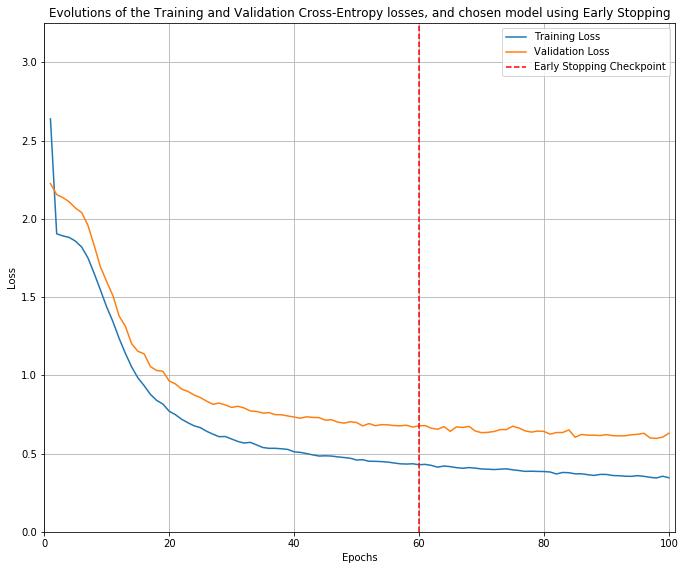

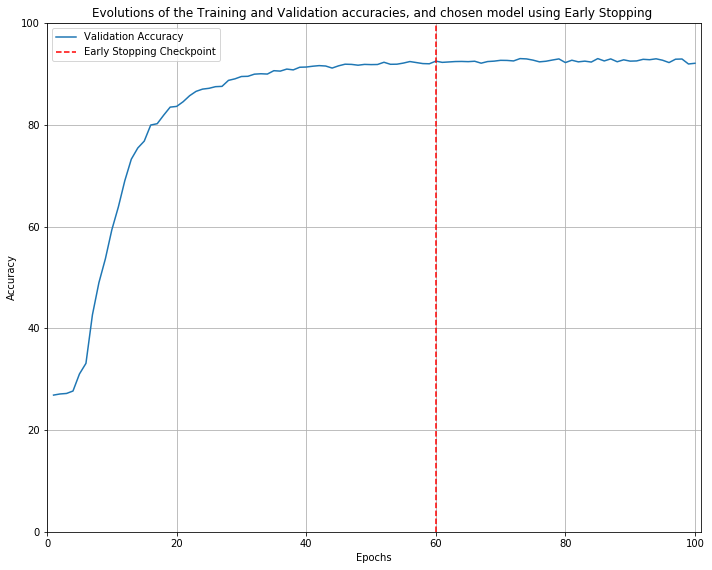


Epoch : 0 Loss : 3.049 
Epoch : 0 Test Acc : 26.960
Epoch : 0 Test Loss : 2.220 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 26.959999084472656 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 1.910 
Epoch : 1 Test Acc : 27.200
Epoch : 1 Test Loss : 2.170 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.24000167846679688 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 1.892 
Epoch : 2 Test Acc : 27.220
Epoch : 2 Test Loss : 2.155 
UPDATE: NEW BEST MODEL
Iterator for early stopping now at 1 since improvement of test accuracy = 0.019998550415039062 <= 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoc

KeyboardInterrupt: 

In [5]:
lr_valid_acc=[]
lr_train_loss=[]
lr_valid_loss=[]

bsize=[16,32]

for bs in bsize:
    
    #create an iterator that will split the data in batches for training
    trainloader = torch.utils.data.DataLoader(train, batch_size=bs)
    testloader = torch.utils.data.DataLoader(test, batch_size=bs)
    validloader = torch.utils.data.DataLoader(X_valid, batch_size=bs)

    clf = Classifier()
    optimizer = torch.optim.Adam(clf.parameters(), lr=0.00008)
    criterion = nn.CrossEntropyLoss()
    epochs=100
    time1=dt.datetime.now()

    #Will print the plots
    avg_train_losses = []
    avg_valid_losses = []
    valid_acc = []
    index_of_best = 0

    #Early stopping criterion: when the test accuracy does not improve by at least #epsilon for #patience epochs in a row, we stop
    patience = 5
    epsilon = 0.1
    patience_iterator = 0
    best_test_acc = 0
    last_acc = 0
    stop = False

    #Training for loop
    for epoch in range(epochs):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
            #print('|', end ="")

        avg_train_losses.append(np.mean(losses))
        print('\nEpoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        clf.eval()
        total = 0
        correct = 0
        losses = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            loss = criterion(outputs, targets)
            losses.append(loss.data)

        avg_valid_losses.append(np.mean(losses))
        test_acc = 100.*correct/total
        valid_acc.append(test_acc)
        print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
        print('Epoch : %d Test Loss : %.3f ' % (epoch, np.mean(losses)))

        if test_acc > best_test_acc and not(stop):
            print('UPDATE: NEW BEST MODEL')
            filename = 'best_model_4_bs_%f.mdl' %bs
            torch.save(clf.state_dict(), filename)
            best_test_acc = test_acc
            index_of_best = epoch
        if test_acc <= last_acc + epsilon:
            patience_iterator = patience_iterator + 1
            print('Iterator for early stopping now at '+str(patience_iterator)+' since improvement of test accuracy = '+str((test_acc-last_acc).item())+' <= '+str(epsilon))
        else:
            patience_iterator = 0
            print('Iterator for early stopping reset to 0 since improvement of test accuracy = '+str((test_acc-last_acc).item())+' > '+str(epsilon))
        if patience_iterator == patience and epoch>40:
            stop = True
            print('Early stopping')

        print('----------------------------------------------------------------------------------------------------------------------------')
        last_acc = test_acc
        clf.train()

    #Training time
    time2=dt.datetime.now()
    print('Training time for '+str(epoch)+' epochs: '+str(time2-time1))
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 3.25) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    #plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
    plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    lr_valid_acc.append(valid_acc)
    lr_train_loss.append(avg_train_losses)
    lr_valid_loss.append(avg_valid_losses)

# LOADING THE BATCH SIZE 16 EARLY STOPPED MODEL

In [21]:
filename = 'best_model_4_bs_%f.mdl' %16

In [ ]:
# %load (filename)
best_model_4_bs_16.000000.mdl

In [25]:
clf.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=8192, out_features=10, bias=True)
)

In [26]:
#Make the final predictions
pred = []
for batch_idx, inputs in enumerate(validloader):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred.extend(predicted.tolist())
final_preds = pd.DataFrame()
final_preds['Id'] = list(range(0,10000))
final_preds['Label'] = pred
final_preds.to_csv('Prediction_3.csv', index=False)

# BATCH SIZE 32 GRAPHS

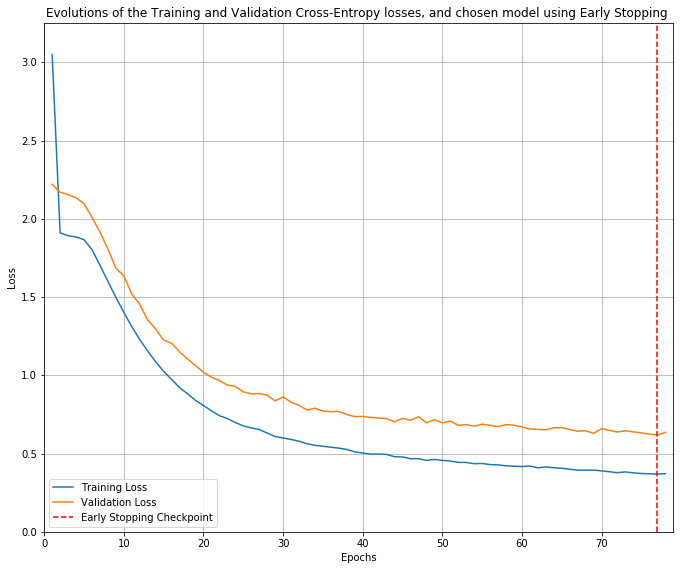

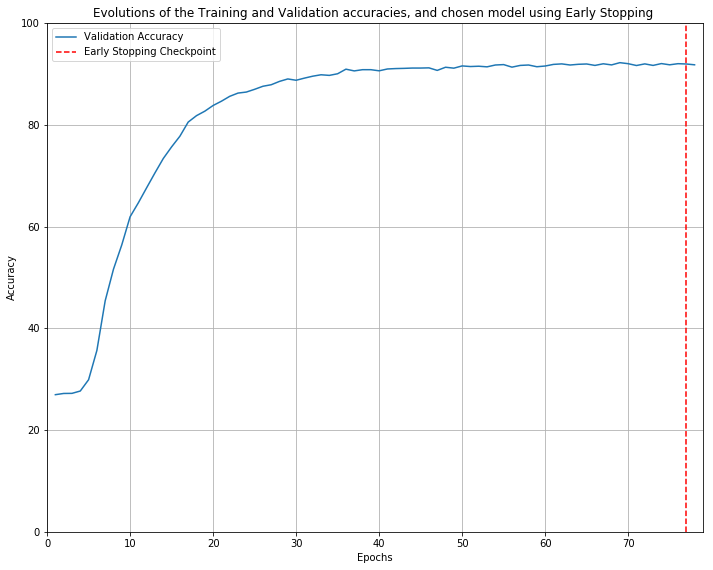

In [9]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3.25) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
#plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# BATCH SIZE 64 and 128 and 512


Epoch : 0 Loss : 3.449 
Epoch : 0 Test Acc : 23.260
Epoch : 0 Test Loss : 2.232 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 23.260000228881836 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 1.946 
Epoch : 1 Test Acc : 26.920
Epoch : 1 Test Loss : 2.175 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 3.6599998474121094 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 1.903 
Epoch : 2 Test Acc : 27.220
Epoch : 2 Test Loss : 2.143 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.2999992370605469 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch 

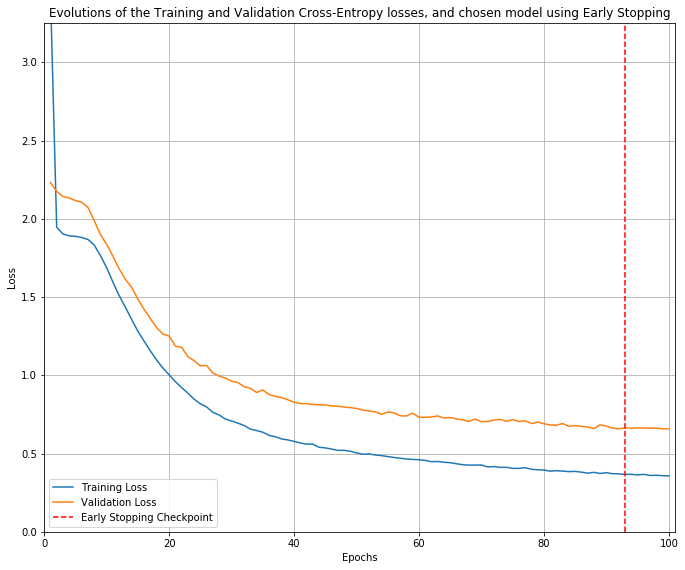

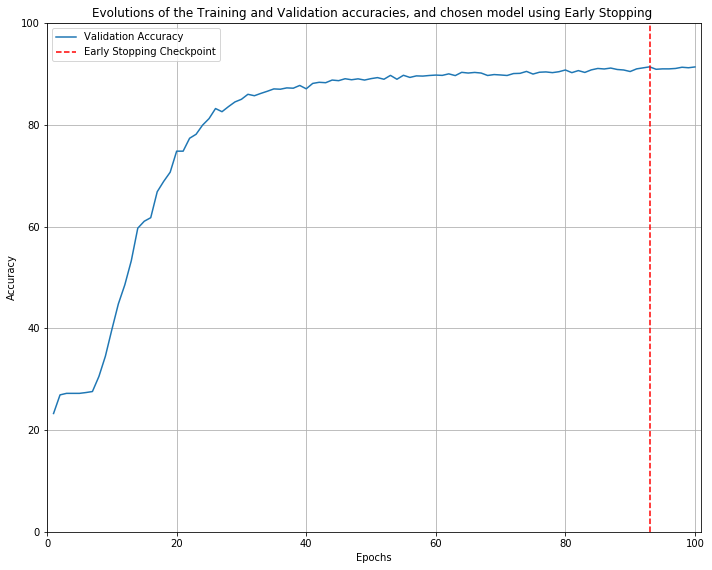


Epoch : 0 Loss : 3.860 
Epoch : 0 Test Acc : 24.020
Epoch : 0 Test Loss : 2.223 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 24.020000457763672 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 2.000 
Epoch : 1 Test Acc : 25.900
Epoch : 1 Test Loss : 2.228 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 1.8799991607666016 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 1.938 
Epoch : 2 Test Acc : 26.580
Epoch : 2 Test Loss : 2.211 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.6800003051757812 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch 

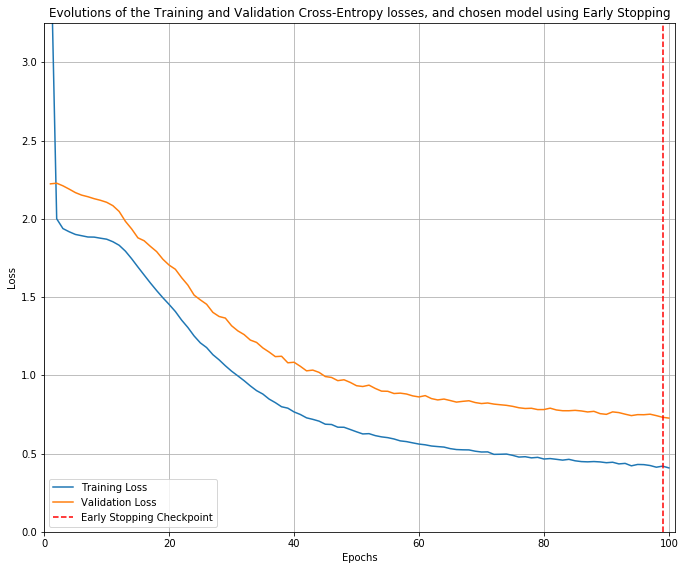

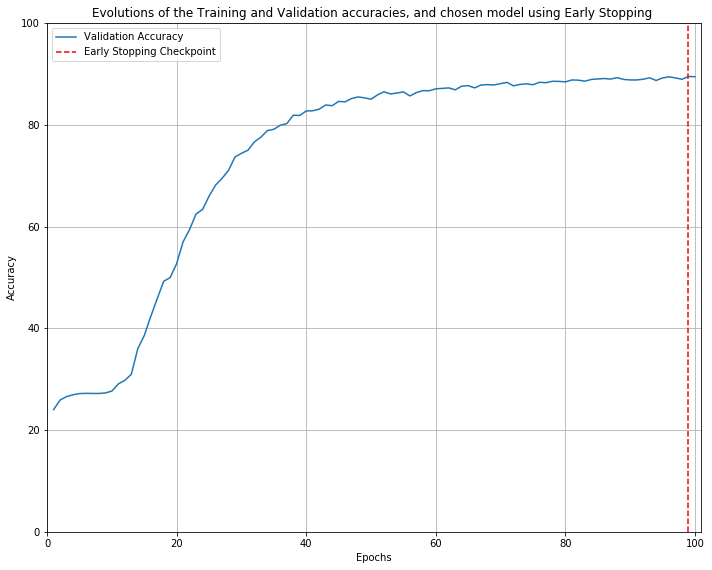


Epoch : 0 Loss : 5.346 
Epoch : 0 Test Acc : 19.320
Epoch : 0 Test Loss : 2.187 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 19.31999969482422 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 2.311 
Epoch : 1 Test Acc : 21.260
Epoch : 1 Test Loss : 2.238 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 1.9400005340576172 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 2.045 
Epoch : 2 Test Acc : 22.740
Epoch : 2 Test Loss : 2.243 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 1.4799995422363281 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch :

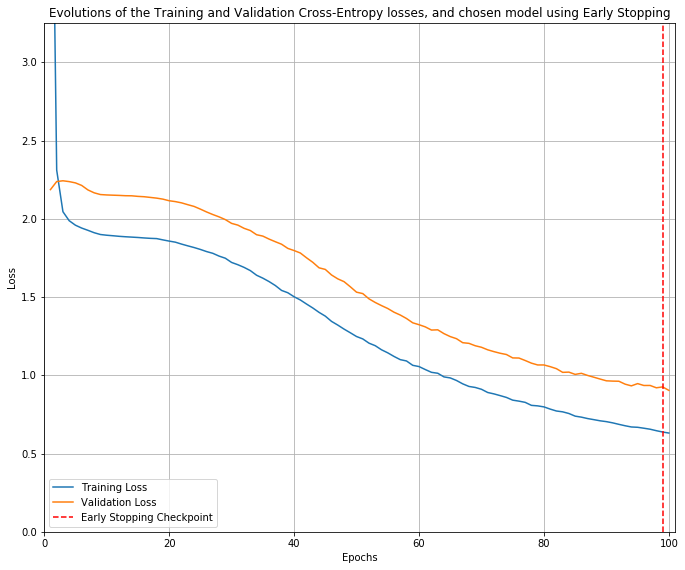

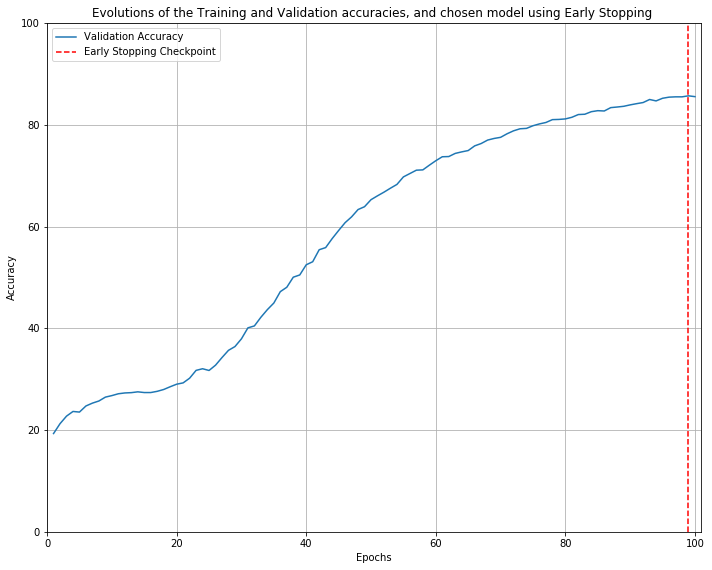

In [4]:
lr_valid_acc=[]
lr_train_loss=[]
lr_valid_loss=[]

bsize=[64,128,512]

for bs in bsize:
    
    #create an iterator that will split the data in batches for training
    trainloader = torch.utils.data.DataLoader(train, batch_size=bs)
    testloader = torch.utils.data.DataLoader(test, batch_size=bs)
    validloader = torch.utils.data.DataLoader(X_valid, batch_size=bs)

    clf = Classifier()
    optimizer = torch.optim.Adam(clf.parameters(), lr=0.00008)
    criterion = nn.CrossEntropyLoss()
    epochs=100
    time1=dt.datetime.now()

    #Will print the plots
    avg_train_losses = []
    avg_valid_losses = []
    valid_acc = []
    index_of_best = 0

    #Early stopping criterion: when the test accuracy does not improve by at least #epsilon for #patience epochs in a row, we stop
    patience = 5
    epsilon = 0.1
    patience_iterator = 0
    best_test_acc = 0
    last_acc = 0
    stop = False

    #Training for loop
    for epoch in range(epochs):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
            #print('|', end ="")

        avg_train_losses.append(np.mean(losses))
        print('\nEpoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        clf.eval()
        total = 0
        correct = 0
        losses = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            loss = criterion(outputs, targets)
            losses.append(loss.data)

        avg_valid_losses.append(np.mean(losses))
        test_acc = 100.*correct/total
        valid_acc.append(test_acc)
        print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
        print('Epoch : %d Test Loss : %.3f ' % (epoch, np.mean(losses)))

        if test_acc > best_test_acc and not(stop):
            print('UPDATE: NEW BEST MODEL')
            filename = 'best_model_4_bs_%f.mdl' %bs
            torch.save(clf.state_dict(), filename)
            best_test_acc = test_acc
            index_of_best = epoch
        if test_acc <= last_acc + epsilon:
            patience_iterator = patience_iterator + 1
            print('Iterator for early stopping now at '+str(patience_iterator)+' since improvement of test accuracy = '+str((test_acc-last_acc).item())+' <= '+str(epsilon))
        else:
            patience_iterator = 0
            print('Iterator for early stopping reset to 0 since improvement of test accuracy = '+str((test_acc-last_acc).item())+' > '+str(epsilon))
        if patience_iterator == patience and epoch>40:
            stop = True
            print('Early stopping')

        print('----------------------------------------------------------------------------------------------------------------------------')
        last_acc = test_acc
        clf.train()

    #Training time
    time2=dt.datetime.now()
    print('Training time for '+str(epoch)+' epochs: '+str(time2-time1))
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 3.25) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    #plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
    plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    lr_valid_acc.append(valid_acc)
    lr_train_loss.append(avg_train_losses)
    lr_valid_loss.append(avg_valid_losses)

# Loading the 32 and 64 model 

In [12]:
filename = 'best_model_4_bs_%f.mdl' %32

In [ ]:
# %load (filename)
best_model_4_bs_32.000000.mdl

In [14]:
clf.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=8192, out_features=10, bias=True)
)

In [15]:
#Make the final predictions
pred = []
for batch_idx, inputs in enumerate(validloader):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred.extend(predicted.tolist())
final_preds = pd.DataFrame()
final_preds['Id'] = list(range(0,10000))
final_preds['Label'] = pred
final_preds.to_csv('Prediction_3.csv', index=False)

In [18]:
filename = 'best_model_4_bs_%f.mdl' %64


In [ ]:
# %load (filename)
best_model_4_bs_64.000000.mdl

In [20]:
#Make the final predictions
pred = []
for batch_idx, inputs in enumerate(validloader):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred.extend(predicted.tolist())
final_preds = pd.DataFrame()
final_preds['Id'] = list(range(0,10000))
final_preds['Label'] = pred
final_preds.to_csv('Prediction_3_64.csv', index=False)

# BATCH SIZE 256


Epoch : 0 Loss : 3.088 
Epoch : 0 Test Acc : 23.340
Epoch : 0 Test Loss : 2.212 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 23.34000015258789 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 2.008 
Epoch : 1 Test Acc : 25.060
Epoch : 1 Test Loss : 2.214 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 1.7199993133544922 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 1.945 
Epoch : 2 Test Acc : 25.780
Epoch : 2 Test Loss : 2.200 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.720001220703125 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 

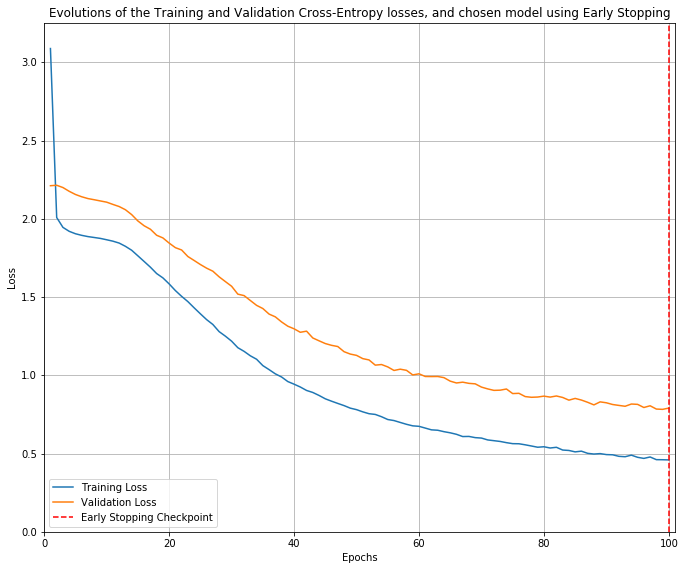

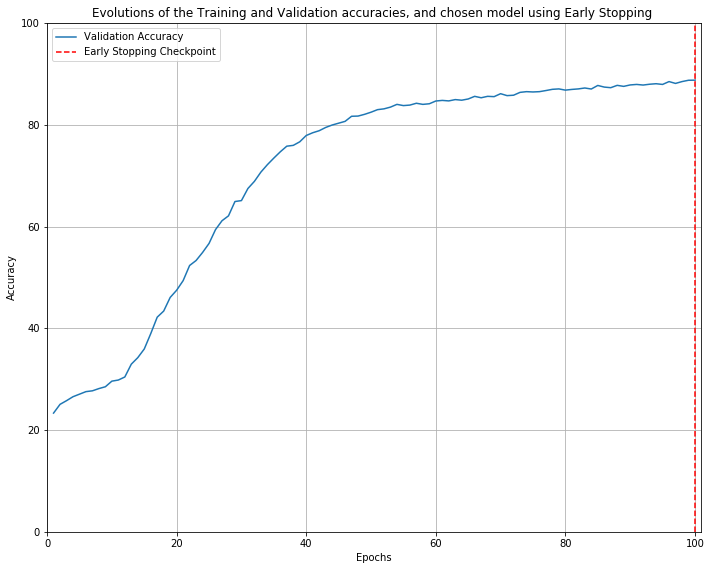

In [6]:
lr_valid_acc=[]
lr_train_loss=[]
lr_valid_loss=[]

bsize=[256]

for bs in bsize:
    
    #create an iterator that will split the data in batches for training
    trainloader = torch.utils.data.DataLoader(train, batch_size=bs)
    testloader = torch.utils.data.DataLoader(test, batch_size=bs)
    validloader = torch.utils.data.DataLoader(X_valid, batch_size=bs)

    clf = Classifier()
    optimizer = torch.optim.Adam(clf.parameters(), lr=0.00008)
    criterion = nn.CrossEntropyLoss()
    epochs=100
    time1=dt.datetime.now()

    #Will print the plots
    avg_train_losses = []
    avg_valid_losses = []
    valid_acc = []
    index_of_best = 0

    #Early stopping criterion: when the test accuracy does not improve by at least #epsilon for #patience epochs in a row, we stop
    patience = 5
    epsilon = 0.1
    patience_iterator = 0
    best_test_acc = 0
    last_acc = 0
    stop = False

    #Training for loop
    for epoch in range(epochs):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
            #print('|', end ="")

        avg_train_losses.append(np.mean(losses))
        print('\nEpoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        clf.eval()
        total = 0
        correct = 0
        losses = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            loss = criterion(outputs, targets)
            losses.append(loss.data)

        avg_valid_losses.append(np.mean(losses))
        test_acc = 100.*correct/total
        valid_acc.append(test_acc)
        print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
        print('Epoch : %d Test Loss : %.3f ' % (epoch, np.mean(losses)))

        if test_acc > best_test_acc and not(stop):
            print('UPDATE: NEW BEST MODEL')
            filename = 'best_model_4_bs_%f.mdl' %bs
            torch.save(clf.state_dict(), filename)
            best_test_acc = test_acc
            index_of_best = epoch
        if test_acc <= last_acc + epsilon:
            patience_iterator = patience_iterator + 1
            print('Iterator for early stopping now at '+str(patience_iterator)+' since improvement of test accuracy = '+str((test_acc-last_acc).item())+' <= '+str(epsilon))
        else:
            patience_iterator = 0
            print('Iterator for early stopping reset to 0 since improvement of test accuracy = '+str((test_acc-last_acc).item())+' > '+str(epsilon))
        if patience_iterator == patience and epoch>40:
            stop = True
            print('Early stopping')

        print('----------------------------------------------------------------------------------------------------------------------------')
        last_acc = test_acc
        clf.train()

    #Training time
    time2=dt.datetime.now()
    print('Training time for '+str(epoch)+' epochs: '+str(time2-time1))
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 3.25) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    #plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
    plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    lr_valid_acc.append(valid_acc)
    lr_train_loss.append(avg_train_losses)
    lr_valid_loss.append(avg_valid_losses)